In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydicom, os, skimage, sys, time,subprocess, glob, timeit
from tqdm import tqdm
import SimpleITK as sitk
from scipy.ndimage.morphology import binary_fill_holes
from shutil import copyfile, move, rmtree


In [4]:
import SimpleITK as sitk

p = sitk.ParameterMap()
# // Example parameter file for rotation registration
# // C-style comments:
# p['Metric'] = ['AdvancedMattesMutualInformation']
p['Metric'] = ['AdvancedNormalizedCorrelation']
# // The internal pixel type, used for internal computations
# // Leave to float in general. 
# // NB: this is not the type of the input images! The pixel 
# // type of the input images is automatically read from the 
# // images themselves.
# // This setting can be changed to "short" to save some memory
# // in case of very large 3D images.
p['FixedInternalImagePixelType'] = ['short']
p['MovingInternalImagePixelType'] = ['short']
# // The dimensions of the fixed and moving image
# // NB: This has to be specified by the user. The dimension of
# // the images is currently NOT read from the images.
# // Also note that some other settings may have to specified
# // for each dimension separately.
# (FixedImageDimension 3)
# //(MovingImageDimension 3)
p['FixedImageDimension'] = ['2']

# // Specify whether you want to take into account the so-called
# // direction cosines of the images. Recommended: true.
# // In some cases, the direction cosines of the image are corrupt,
# // due to image format conversions for example. In that case, you 
# // may want to set this option to "false".
p['UseDirectionCosines'] = ['true']

# // **************** Main Components **************************

# // The following components should usually be left as they are:
p['Registration'] = ['MultiResolutionRegistration']
p['Interpolator'] = ['BSplineInterpolator']
p['ResampleInterpolator'] = ['FinalBSplineInterpolator']
p['Resampler'] = ['DefaultResampler']

# // These may be changed to Fixed/MovingSmoothingImagePyramid.
# // See the manual.
p['FixedImagePyramid'] = ['FixedRecursiveImagePyramid']
p['MovingImagePyramid'] = ['MovingRecursiveImagePyramid']
# //(FixedImagePyramid "FixedSmoothingImagePyramid")
# //(MovingImagePyramid "MovingSmoothingImagePyramid")
# // The following components are most important:
# // The optimizer AdaptiveStochasticGradientDescent (ASGD) works
# // quite ok in general. The Transform and Metric are important
# // and need to be chosen careful for each application. See manual.
# (MT:AdvancedMattesMutualInformation, Transform option "Affine")
# (Bob for between modalities MRI-NCCT-CTA: AdvancedNormalizedCorrelation)
p['Optimizer'] = ['AdaptiveStochasticGradientDescent']
p['Transform'] = ['EulerTransform']
# //(Transform "AffineTransform")

# // ***************** Transformation **************************

# // Scales the rotations compared to the translations, to make
# // sure they are in the same range. In general, it's best to  
# // use automatic scales estimation:
p['AutomaticScalesEstimation'] = ['true']

# // Automatically guess an initial translation by aligning the
# // geometric centers of the fixed and moving.
p['AutomaticTransformInitialization'] = ['true']
# // Whether transforms are combined by composition or by addition.
# // In generally, Compose is the best option in most cases.
# // It does not influence the results very much.
p['HowToCombineTransforms'] = ['Compose']
# // ******************* Similarity measure *********************

# // Number of grey level bins in each resolution level,
# // for the mutual information. 16 or 32 usually works fine.
# // You could also employ a hierarchical strategy:
# //(NumberOfHistogramBins 16 32 64)
p['NumberOfHistogramBins'] = ['64']
# // If you use a mask, this option is important. 
# // If the mask serves as region of interest, set it to false.
# // If the mask indicates which pixels are valid, then set it to true.
# // If you do not use a mask, the option doesn't matter. 
p['ErodeMask'] = ['false']
# // ******************** Multiresolution **********************

# // The number of resolutions. 1 Is only enough if the expected
# // deformations are small. 3 or 4 mostly works fine. For large
# // images and large deformations, 5 or 6 may even be useful. pm: Pyramid in voxels of geometric space (check anisotropy)
p['NumberOfResolutions'] = ['6']
# // The downsampling/blurring factors for the image pyramids.
# // By default, the images are downsampled by a factor of 2
# // compared to the next resolution.
# // So, in 2D, with 4 resolutions, the following schedule is used:
# //(ImagePyramidSchedule 8 8  4 4  2 2  1 1 )
# // And in 3D:
# //(ImagePyramidSchedule 8 8 8  4 4 4  2 2 2  1 1 1 )
# // You can specify any schedule, for example:
# //(ImagePyramidSchedule 4 4  4 3  2 1  1 1 )
# // Make sure that the number of elements equals the number
# // of resolutions times the image dimension.

# // ******************* Optimizer ****************************

# // Maximum number of iterations in each resolution level:
# // 200-500 works usually fine for rigid registration.
# // For more robustness, you may increase this to 1000-2000.
p['MaximumNumberOfIterations'] = ['500']
# // The step size of the optimizer, in mm. By default the voxel size is used.
# // which usually works well. In case of unusual high-resolution images
# // (eg histology) it is necessary to increase this value a bit, to the size
# // of the "smallest visible structure" in the image:
p['MaximumStepLength'] = ['1.0']
# // **************** Image sampling **********************

# // Number of spatial samples used to compute the mutual
# // information (and its derivative) in each iteration.
# // With an AdaptiveStochasticGradientDescent optimizer,
# // in combination with the two options below, around 2000
# // samples may already suffice. pm: choose more samples --> more samples
# //(NumberOfSpatialSamples 4096) #// use 4096 if to many samples map outside of moving image --> did not work
p['NumberOfSpatialSamples'] = ['2048'] #// default is 2048
# // Refresh these spatial samples in every iteration, and select
# // them randomly. See the manual for information on other sampling
# // strategies.
p['NewSamplesEveryIteration'] = ['true']
p['ImageSampler'] = ['Random']
# // ************* Interpolation and Resampling ****************

# // Order of B-Spline interpolation used during registration/optimisation.
# // It may improve accuracy if you set this to 3. Never use 0.
# // An order of 1 gives linear interpolation. This is in most 
# // applications a good choice.
p['BSplineInterpolationOrder'] = ['1']
# // Order of B-Spline interpolation used for applying the final
# // deformation.
# // 3 gives good accuracy; recommended in most cases.
# // 1 gives worse accuracy (linear interpolation)
# // 0 gives worst accuracy, but is appropriate for binary images
# // (masks, segmentations); equivalent to nearest neighbor interpolation.
p['FinalBSplineInterpolationOrder'] = ['3']
# //Default pixel value for pixels that come from outside the picture:
p['DefaultPixelValue'] = ['0']
# // Choose whether to generate the deformed moving image.
# // You can save some time by setting this to false, if you are
# // only interested in the final (nonrigidly) deformed moving image
# // for example.
p['WriteResultImage'] = ['false']
# // The pixel type and format of the resulting deformed moving image
p['ResultImagePixelType'] = ['short']
p['ResultImageFormat'] = ["nii.gz"]

In [5]:
def Clipper(CTP_sitk, minimum=-1024, maximum=1900):
    """
    Clip values of input with numpy.clip, with minimum and maximum as min/max.
    Returns clipped array.

    """
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    CTP_array = np.clip(CTP_array, minimum, maximum)
    CTP_sitk = np2itk(CTP_array,CTP_sitk)
    return CTP_sitk
def np2itk(arr, original_img):
    if len(arr.shape) == 4:
        t_dim = arr.shape[0]
        frames = []
        for t in range(t_dim):
            frames.append(sitk.GetImageFromArray(arr[t], False))
        img = sitk.JoinSeries(frames)
    elif len(arr.shape) == 3:
        img = sitk.GetImageFromArray(arr, False)
        
    img.SetSpacing(original_img.GetSpacing())
    img.SetOrigin(original_img.GetOrigin())
    img.SetDirection(original_img.GetDirection())
    # this does not allow cropping (such as removing thorax, neck)
    img.CopyInformation(original_img) 
    return img


In [6]:
def Flipper(CTP_sitk):
    """
    Clip values of input with numpy.clip, with minimum and maximum as min/max.
    Returns clipped array.

    """
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    if len(CTP_array.shape) == 4:
        CTP_array = np.flip(CTP_array, axis = 3)
    else:
        CTP_array = np.flip(CTP_array, axis = 2)

    CTP_sitk = np2itk(CTP_array,CTP_sitk)
    return CTP_sitk

In [7]:
def NonZero(CTP_sitk):
    """
    Clip values of input with numpy.clip, with minimum and maximum as min/max.
    Returns clipped array.

    """
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    CTP_array[np.nonzero(CTP_array)] = 1
    CTP_sitk = np2itk(CTP_array,CTP_sitk)
    return CTP_sitk

In [8]:
def Inverse(sitk_img):
    """
    Inverse values of input with numpy.clip, with minimum and maximum as min/max.
    Returns clipped array.

    """
    array = sitk.GetArrayFromImage(sitk_img) # T x D x H x W

    rever = np.ones(array.shape)
    rever[np.nonzero(array)] = 0
    result = np2itk(rever,sitk_img)
    
    result.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return result
def BrainMask(files, inverse=False):
    """
    Clip values of input with numpy.clip, with minimum and maximum as min/max.
    Returns clipped array.

    """
    first_file = files[0]
    empty = np.zeros(sitk.GetArrayFromImage(first_file).shape)
    for file in files:
        array = sitk.GetArrayFromImage(file) # T x D x H x W
        array[np.nonzero(array)] = 1
        empty += array
    
    empty[np.nonzero(empty)] = 1
    if not inverse:
        result = np2itk(empty,first_file)
    else:
        rever = np.ones(empty.shape)
        rever[np.nonzero(empty)] = 0
        result = np2itk(rever,first_file)
    result.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return result

def np_slicewise(mask, funcs, repeats=1):
    """
    Fills holes slice by slice of an 3D np volume
    """
    if isinstance(mask,sitk.SimpleITK.Image):
        mask = sitk.GetArrayFromImage(mask)
    out = np.zeros_like(mask)
    for sliceno in range(mask.shape[0]):
        m = mask[sliceno,:,:]
        for r in range(repeats):
            for func in funcs:
                m = func(m)
        out[sliceno,:,:] = m
    return out
def LargestConnectedComponent3D(img,min_threshold=0, background=0):
    """
    Retrieves largest connected component mask for 3D sitk
    """
    # compute connected components (in 3D)
    cc = sitk.ConnectedComponent(img>min_threshold)
    stats = sitk.LabelIntensityStatisticsImageFilter()
    stats.Execute(cc,img)
    max_size = 0
    # get largest connected component
    for l in stats.GetLabels():
        if stats.GetPhysicalSize(l)>max_size:
            max_label = l
            max_size = stats.GetPhysicalSize(l)
    # return mask
    return sitk.BinaryThreshold(cc, max_label, max_label+1e-2)
def WritePerVolume(CTP_sitk, save_path, flipped=False):
#     sitk.WriteImage(CTP_sitk, os.path.join(save_path,'ctp_4d.nii.gz'))
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    t_dim = CTP_array.shape[0]
    for t in range(t_dim):
        im = sitk.GetImageFromArray(CTP_array[t])
        im.SetSpacing(CTP_sitk.GetSpacing())
        im.SetOrigin(CTP_sitk.GetOrigin())
        if not flipped:
            sitk.WriteImage(im, os.path.join(save_path, 'ctp_3d_{}.nii.gz'.format(t)))
        else:
            sitk.WriteImage(im, os.path.join(save_path, 'ctp_3d_{}_flipped.nii.gz'.format(t)))

        
def WritePerSlice(CTP_sitk, save_path, prefix, flipped=False):
#     sitk.WriteImage(CTP_sitk, os.path.join(save_path,'ctp_4d.nii.gz'))
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    d_dim = CTP_array.shape[1]
    for d in range(d_dim):
        im = sitk.GetImageFromArray(CTP_array[:,d,:,:])
        im.SetSpacing(CTP_sitk.GetSpacing())
        im.SetOrigin(CTP_sitk.GetOrigin())
        if not flipped:
            if d < 10:
                sitk.WriteImage(im, os.path.join(save_path, '{}_0{}.nii.gz'.format(prefix,d)))
            else:
                sitk.WriteImage(im, os.path.join(save_path, '{}_{}.nii.gz'.format(prefix,d)))

        else:
            if d < 10:
                sitk.WriteImage(im, os.path.join(save_path, '{}_0{}_flipped.nii.gz'.format(prefix,d)))

            else:
                sitk.WriteImage(im, os.path.join(save_path, '{}_{}_flipped.nii.gz'.format(prefix,d)))


In [9]:
def ApplyMask(MASK_sitk, CTP_sitk, foreground_m=1, background=None, sitk_type = sitk.sitkInt32):
    """
    Applies mask (m) to 4D volume, sets background of image
    returns and 4D volume with only mask foreground.
    """
    if foreground_m == 0:
        mf = sitk.MaskNegatedImageFilter()
    elif foreground_m == 1:
        mf = sitk.MaskImageFilter()
    if background != None:
        mf.SetOutsideValue(background)
        
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    MASK_array = sitk.GetArrayFromImage(MASK_sitk) # T x D x H x W
    t_dim = CTP_array.shape[0]
    frames = []
    for t in range(t_dim):
        im = sitk.GetImageFromArray(CTP_array[t])
        im = sitk.Cast(im,sitk_type)
        
        mask = sitk.GetImageFromArray(MASK_array)
        mask = sitk.Cast(mask,sitk_type)
        
        result = mf.Execute(im, mask)
        frames.append(result)
        
    img = sitk.JoinSeries(frames)
    # restore original spacing, origin, direction...
    img.SetSpacing(CTP_sitk.GetSpacing())
    img.SetOrigin(CTP_sitk.GetOrigin())
    img.SetDirection(CTP_sitk.GetDirection())
    img.CopyInformation(CTP_sitk) 

    return img

In [44]:
ctp_paths = glob.glob(r'D:\TRAINING\*\*4DPWI*\*4DPWI*.nii')
mask_paths = glob.glob(r'D:\TRAINING\*\*OT*\*OT*.nii')

cbv_paths = glob.glob(r'D:\TRAINING\*\*CBV*\*CBV*.nii')
cbf_paths = glob.glob(r'D:\TRAINING\*\*CBF*\*CBF*.nii')
tmax_paths = glob.glob(r'D:\TRAINING\*\*Tmax*\*Tmax*.nii')
mtt_paths = glob.glob(r'D:\TRAINING\*\*MTT*\*MTT*.nii')
ncct_paths = glob.glob(r'D:\TRAINING\*\*CT*\*CT*.nii')

savepath = r'D:\ISLES'


In [115]:
sitk.GetArrayFromImage(sitk.ReadImage(ctp_paths[0])).shape

(49, 8, 256, 256)

In [45]:
for ix, ctp_path in tqdm(enumerate(ctp_paths)):
    # Make save folder with casename
    case_id = ctp_path.split('\\')[2].split('_')[1]

    folder = os.path.join(savepath,case_id.zfill(2))
    if not os.path.exists(folder):
        os.makedirs(folder)
    # Move segmentation mask
    seg_mask_sitk = sitk.ReadImage(mask_paths[ix])
    sitk.WriteImage(seg_mask_sitk, os.path.join(folder,'segmentation.nii.gz'))
        
    # Read CTP
    ctp_sitk = sitk.ReadImage(ctp_path)
    ctp_sitk = sitk.Cast(ctp_sitk, sitk.sitkInt32)
    # Get first frame (for np2itk)
    size = list(ctp_sitk.GetSize())
    index = [0, 0, 0, 0]
    size[3] = 0
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    first_frame = extractor.Execute(ctp_sitk)
    
    number_of_slices = size[2]
    mid_slice = number_of_slices // 2

    # Clip CTP and save
    ctp_sitk = Clipper(ctp_sitk, 0, 500)
    
    # Load parameter maps to get brain mask
    cbv_sitk = sitk.ReadImage(cbv_paths[ix])
    cbf_sitk = sitk.ReadImage(cbf_paths[ix])
    tmax_sitk = sitk.ReadImage(tmax_paths[ix])
    mtt_sitk = sitk.ReadImage(mtt_paths[ix])
    ncct_sitk = sitk.ReadImage(ncct_paths[ix])

    sitk.WriteImage(cbv_sitk, os.path.join(folder,'cbv.nii.gz'))
    sitk.WriteImage(cbf_sitk, os.path.join(folder,'cbf.nii.gz'))
    sitk.WriteImage(tmax_sitk, os.path.join(folder,'tmax.nii.gz'))
    sitk.WriteImage(mtt_sitk, os.path.join(folder,'mtt.nii.gz'))
    sitk.WriteImage(ncct_sitk, os.path.join(folder,'ncct.nii.gz'))

    
    sitk.WriteImage(seg_mask_sitk, os.path.join(folder,'segmentation.nii.gz'))
    # Calculate brain mask and save
    mask = BrainMask([cbv_sitk, cbf_sitk, tmax_sitk, mtt_sitk])
    conn = LargestConnectedComponent3D(mask)
    mask = np_slicewise(conn, [binary_fill_holes])
    mask = np2itk(mask,first_frame)
    save_file_mask = os.path.join(folder,'brainmask.nii.gz')
    sitk.WriteImage(mask, save_file_mask)
    
    # Apply mask to CTP
    
    ctp_sitk = ApplyMask(mask, ctp_sitk)
    ctp_sitk = sitk.Cast(ctp_sitk, sitk.sitkInt32)
    sitk.WriteImage(ctp_sitk, os.path.join(folder,'ctp.nii.gz'))
    
    # Clip CTP and save flipped
    ctp_sitk_flipped = Flipper(ctp_sitk)

    # Flip mask and save flipped
    mask_flipped = Flipper(mask)
    save_file_mask = os.path.join(folder,'brainmask_flipped.nii.gz')
    sitk.WriteImage(mask_flipped, save_file_mask)
    
    # Determine transformation
    fix = mask
    mov = mask_flipped
    
    # Only use central slice
    size = list(fix.GetSize())
    index = [0, 0, mid_slice]
    size[2] = 0
    extractor = sitk.ExtractImageFilter()
    extractor.SetSize(size)
    extractor.SetIndex(index)
    fix = extractor.Execute(fix)
    mov = extractor.Execute(mov)

    elastixImageFilter = sitk.ElastixImageFilter()
    elastixImageFilter.LogToConsoleOn()

    elastixImageFilter.SetParameterMap(p)
    elastixImageFilter.PrintParameterMap()
    elastixImageFilter.SetFixedImage(fix)
    elastixImageFilter.SetMovingImage(mov)
    elastixImageFilter.Execute()
    # Get transform parameters
    TranformParameters = elastixImageFilter.GetTransformParameterMap()
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetTransformParameterMap(TranformParameters)
    sitk.PrintParameterMap(transformixImageFilter.GetTransformParameterMap()[0])
    # transformixImageFilter.SetTransformParameter('FinalBSplineInterpolationOrder', '0')
    transformixImageFilter.SetTransformParameter('ResultImagePixelType', 'short')
#     transformixImageFilter.SetTransformParameter('CompressResultImage', 'true')
    transformixImageFilter.SetTransformParameter('WriteResultImage', 'false')
    sitk.PrintParameterMap(transformixImageFilter.GetTransformParameterMap()[0])
    
    # Perfom transformation with new parameters
    series = []
    mov = mask_flipped
    size = list(mov.GetSize())
    size[2] = 0
    for jx in range(number_of_slices):
        # Only use central slice
        index = [0, 0, jx]
        extractor = sitk.ExtractImageFilter()
        extractor.SetSize(size)
        extractor.SetIndex(index)
        mov_slice = extractor.Execute(mov)
        
        transformixImageFilter.SetMovingImage(mov_slice)
        transformixImageFilter.Execute()
        results = transformixImageFilter.GetResultImage()
        series.append(results)
    final_result = sitk.JoinSeries(series)
    final_result.CopyInformation(mask_flipped)
    sitk.WriteImage(final_result,  os.path.join(folder,'braimask_registered_tfx.nii.gz'))
    
    size = list(ctp_sitk_flipped.GetSize())
    series = []
    
    # Select first fixed frame
    timesteps = size[3]
    for t in range(0, timesteps):
        # Select frame
        size = list(ctp_sitk_flipped.GetSize())
        size[3] = 0

        index = [0, 0, 0, t]  
        extractor = sitk.ExtractImageFilter()
        extractor.SetSize(size)
        extractor.SetIndex(index)
        mov = extractor.Execute(ctp_sitk_flipped)
        
        # Now, apply transform to each slice at this timestep
        sub_series = []
        size = list(mov.GetSize())
        size[2] = 0
        for jx in range(number_of_slices):
            index = [0, 0, jx]
            extractor = sitk.ExtractImageFilter()
            extractor.SetSize(size)
            extractor.SetIndex(index)
            mov_slice = extractor.Execute(mov)

            transformixImageFilter.SetMovingImage(mov_slice)
            transformixImageFilter.Execute()
            results = transformixImageFilter.GetResultImage()
            sub_series.append(results)
            
        intermediate_result = sitk.JoinSeries(sub_series)
        series.append(intermediate_result)
        
    final_result = sitk.JoinSeries(series)
    final_result.CopyInformation(ctp_sitk) 
    final_result = sitk.Cast(final_result, sitk.sitkInt32)
    sitk.WriteImage(final_result,  os.path.join(folder,'ctp_flipped_and_registered.nii.gz'))
    


94it [01:03,  1.48it/s]


In [30]:
from matplotlib.colors import LogNorm

In [130]:
ctps_flipped = glob.glob(r'D:\ISLES\*\ctp_flipped_and_registered.nii.gz')
ctps = glob.glob(r'D:\ISLES\*\ctp.nii.gz')
masks = glob.glob(r'D:\ISLES\*\segmentation.nii.gz')

In [131]:
from skimage.exposure import equalize_hist
from einops.einops import rearrange

In [132]:
def preprocessor(nifti, clip_value): #3D nifti
    # Clip entire 4D volume
    nifti = np.clip(nifti, 0, clip_value)
    # Equalize entire histogram
    nifti = equalize_hist(nifti, nbins=20000, mask=(nifti > 0))
    nifti = nifti - np.min(nifti)
    # Shift distribution, not the zeroes
    mask=(nifti > 0)
    mdata = np.ma.masked_array(nifti, mask=~mask.astype(bool))
    mdata =(mdata - 0.5)
    mdata.mask = np.ma.nomask
    return mdata

In [144]:
import nibabel as nib

In [146]:
for ix, ctp in tqdm(enumerate(ctps)):
    print('patient', ix)
    case_id = ctp.split('\\')[2]#.split('_')[1]
#     sitk_ctp = sitk.ReadImage(ctps[ix])
#     array_ctp = sitk.GetArrayFromImage(sitk_ctp)
    
#     sitk_ctp_flipped = sitk.ReadImage(ctps_flipped[ix])
#     array_ctp_flipped = sitk.GetArrayFromImage(sitk_ctp_flipped)
    
#     sitk_mask = sitk.ReadImage(masks[ix])
#     array_mask = sitk.GetArrayFromImage(sitk_mask)
#     sitk.WriteImage(sitk_mask, os.path.join(r'D:\ISLES_DATA_PROCESSED', 'COMPLETE_MASK','case_{}.nii.gz'.format(case_id)))      
    nii = nib.load(masks[ix])
    nib.save(nii, os.path.join(r'C:\Users\lucasdevries\surfdrive\Projects\surfsara-project\data\modality_sym_noskul_nib\COMPLETE_MASK','case_{}.nii'.format(case_id)))
#     # Clip values
#     array_ctp = np.clip(array_ctp, 0, 500)
#     array_ctp_flipped = np.clip(array_ctp_flipped, 0, 500)
    
#     empty = np.zeros((2, *array_ctp.shape))
#     empty[0] = array_ctp
#     empty[1] = array_ctp_flipped

#     # Equalize entire histogram
#     empty = equalize_hist(empty, nbins=20000, mask=(empty > 0))
#     empty = empty - np.min(empty)
    
#     # Shift distribution, not the zeroes
#     mask = (empty > 0)
#     mdata = np.ma.masked_array(empty, mask=~mask.astype(bool))
#     mdata = (mdata - 0.5)
#     mdata.mask = np.ma.nomask
    
#     # Save flipped and normal part separately
#     array_ctp = mdata[0]
#     array_ctp_flipped = mdata[1]
    
#     sitk_ctp = np2itk(array_ctp, sitk_ctp)
#     sitk_ctp_flipped = np2itk(array_ctp_flipped, sitk_ctp_flipped)
#     sitk.WriteImage(sitk_ctp, os.path.join(r'D:\ISLES', case_id, 'ctp_heq.nii.gz'))
#     sitk.WriteImage(sitk_ctp_flipped, os.path.join(r'D:\ISLES', case_id, 'ctp_flipped_heq.nii.gz'))
    
# #     # Define smoothing kernel
# #     module = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, padding=0, bias=False, stride=2)
# #     module = module.float()
# #     module.weight.data = torch.tensor([[[.25, .5, .25]]]).float()
# #     # Model expects (B, C=1, T)
# #     array_ctp = torch.tensor(array_ctp)
# #     array_ctp = rearrange(array_ctp, 'T Z H W -> (Z H W) T').unsqueeze(1)
# #     out = module(array_ctp.float())
# #     out = rearrange(out, '(Z H W) C T -> (C T) Z H W ', H=256, W=256)

# #     array_ctp_flipped = torch.tensor(array_ctp_flipped)
# #     array_ctp_flipped = rearrange(array_ctp_flipped, 'T Z H W -> (Z H W) T').unsqueeze(1)
# #     out_flipped = module(array_ctp_flipped.float())
# #     out_flipped = rearrange(out_flipped, '(Z H W) C T -> (C T) Z H W  ', H=256, W=256)
    
# #     empty = np.zeros((2, *out.detach().numpy().shape))
# #     empty[0] = out.detach().numpy()
# #     empty[1] = out_flipped.detach().numpy()
    
#     empty = np.zeros((2, *array_ctp.shape))
#     empty[0] = array_ctp
#     empty[1] = array_ctp_flipped
    
#     # Split on slice
#     depth = array_mask.shape[0]
    
#     size = list(sitk_mask.GetSize())
#     # Select frame
#     size[2] = 0

#     index = [0, 0, 0]  
#     extractor = sitk.ExtractImageFilter()
#     extractor.SetSize(size)
#     extractor.SetIndex(index)
#     slice_of_mask = extractor.Execute(sitk_mask)
    
#     print(slice_of_mask.GetSpacing())
    
#     for ix in range(depth):
#         print('iter slice', ix)
#         print(empty.shape)
#         # Check if mask contains infarct
#         infarct = np.sum(array_mask[ix]) > 0        
#         if infarct:
#             # Save slices. 
#             scan_slice = sitk.GetImageFromArray(empty[:,:,ix,:,:], isVector=False)
# #             scan_slice.CopyInformation(slice_of_mask)
#             mask_slice = sitk.GetImageFromArray(array_mask[ix])
#             mask_slice.CopyInformation(slice_of_mask)
#             print(mask_slice.GetSpacing())

#             ix_str = str(ix).zfill(2)
#             # save somewhere
# #             sitk.WriteImage(scan_slice, os.path.join(r'D:\ISLES', case_id, 'case_{}_{}_ctp.nii.gz'.format(case_id, ix_str)))
# #             sitk.WriteImage(mask_slice, os.path.join(r'D:\ISLES', case_id, 'case_{}_{}_mask.nii.gz'.format(case_id, ix_str)))
# #             sitk.WriteImage(scan_slice, os.path.join(r'D:\ISLES_DATA_NO_SMOOTHING', 'CTP' ,'case_{}_{}.nii.gz'.format(case_id, ix_str)))
# #             sitk.WriteImage(mask_slice, os.path.join(r'D:\ISLES_DATA_NO_SMOOTHING', 'MASK','case_{}_{}.nii.gz'.format(case_id, ix_str)))      
            
#         else:
#             continue
    

    

12it [00:00, 119.99it/s]

patient 0
patient 1
patient 2
patient 3
patient 4
patient 5
patient 6
patient 7
patient 8
patient 9
patient 10
patient 11
patient 12
patient 13
patient 14
patient 15
patient 16
patient 17
patient 18
patient 19
patient 20
patient 21
patient 22
patient 23
patient 24
patient 25
patient 26
patient 27
patient 28


49it [00:00, 144.18it/s]

patient 29
patient 30
patient 31
patient 32
patient 33
patient 34
patient 35
patient 36
patient 37
patient 38
patient 39
patient 40
patient 41
patient 42
patient 43
patient 44
patient 45
patient 46
patient 47
patient 48
patient 49
patient 50
patient 51
patient 52
patient 53
patient 54
patient 55
patient 56
patient 57
patient 58
patient 59
patient 60
patient 61
patient 62
patient 63
patient 64


85it [00:00, 149.60it/s]

patient 65
patient 66
patient 67
patient 68
patient 69
patient 70
patient 71
patient 72
patient 73
patient 74
patient 75
patient 76
patient 77
patient 78
patient 79
patient 80
patient 81
patient 82
patient 83
patient 84
patient 85
patient 86
patient 87
patient 88


94it [00:00, 152.34it/s]

patient 89
patient 90
patient 91
patient 92
patient 93


In [95]:
import torch

inputs = torch.randn(64, 1, 300)
module = torch.nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, padding=0, bias=False, stride=2)
# module.weight.data = torch.tensor([[[.25, .5, .25]]])
module.weight.data
# out = module(inputs)

tensor([[[ 0.2601, -0.1612,  0.3642],
         [-0.0803, -0.1800,  0.1866]],

        [[ 0.1970,  0.3752, -0.2617],
         [ 0.2528,  0.3188,  0.0572]]])

In [1]:
# doe not work for case 18


# for ix, ctp_path in tqdm(enumerate(ctp_paths[9:10])):
#     ix+=9
#     # Make save folder with casename
#     case_id = ctp_path.split('\\')[2].split('_')[1]

#     folder = os.path.join(savepath,case_id.zfill(2))
#     if not os.path.exists(folder):
#         os.makedirs(folder)
        
#     # Read CTP
#     ctp_sitk = sitk.ReadImage(ctp_path)
#     ctp_sitk = sitk.Cast(ctp_sitk, sitk.sitkInt32)
#     print(ctp_sitk)
    
#     size = list(ctp_sitk.GetSize())
#     index = [0, 0, 0, 0]
#     size[3] = 0
#     extractor = sitk.ExtractImageFilter()
#     extractor.SetSize(size)
#     extractor.SetIndex(index)
#     first_frame = extractor.Execute(ctp_sitk)
#     # Clip CTP and save
#     ctp_sitk = Clipper(ctp_sitk, 0, 500)
    
#     # Load parameter maps to get brain mask
#     cbv_sitk = sitk.ReadImage(cbv_paths[ix])
#     cbf_sitk = sitk.ReadImage(cbf_paths[ix])
#     tmax_sitk = sitk.ReadImage(tmax_paths[ix])
#     mtt_sitk = sitk.ReadImage(mtt_paths[ix])
#     print(cbv_paths[ix], ctp_path)
#     # Calculate brain mask and save
#     mask = BrainMask([cbv_sitk, cbf_sitk, tmax_sitk, mtt_sitk])
#     conn = LargestConnectedComponent3D(mask)
#     mask = np_slicewise(conn, [binary_fill_holes])
#     mask = np2itk(mask,first_frame)
#     save_file_mask = os.path.join(folder,'brainmask.nii.gz')
#     sitk.WriteImage(mask, save_file_mask)
    
#     # Apply mask to CTP
    
#     ctp_sitk = ApplyMask(mask, ctp_sitk)
#     ctp_sitk = sitk.Cast(ctp_sitk, sitk.sitkInt32)
#     sitk.WriteImage(ctp_sitk, os.path.join(folder,'ctp.nii.gz'))

# #     # Save also inverse mask
# #     mask_inv = Inverse(mask)
# #     save_file_mask_inv = os.path.join(folder,'brainmask_inv.nii.gz')
# #     sitk.WriteImage(mask_inv, save_file_mask_inv)
    
#     # Clip CTP and save flipped
#     ctp_sitk_flipped = Flipper(ctp_sitk)

#     # Flip mask and save flipped
#     mask_flipped = Flipper(mask)
#     save_file_mask = os.path.join(folder,'brainmask_flipped.nii.gz')
#     sitk.WriteImage(mask_flipped, save_file_mask)
    
#     # Determine transformation
#     fix = mask
#     mov = mask_flipped

#     elastixImageFilter = sitk.ElastixImageFilter()
#     elastixImageFilter.LogToConsoleOn()

#     elastixImageFilter.SetParameterMap(p)
#     elastixImageFilter.PrintParameterMap()
#     elastixImageFilter.SetFixedImage(fix)
#     elastixImageFilter.SetMovingImage(mov)
#     elastixImageFilter.Execute()
#     print('registration completed')
#     # Get transform parameters
#     TranformParameters = elastixImageFilter.GetTransformParameterMap()
#     x, y, z, xx, yy, zz = TranformParameters[0]['TransformParameters']
#     # set rotation to zero in this direction
#     y = 0
#     z = zz = 0
#     transformixImageFilter = sitk.TransformixImageFilter()
#     transformixImageFilter.LogToConsoleOff()
#     transformixImageFilter.SetTransformParameterMap(TranformParameters)
#     sitk.PrintParameterMap(transformixImageFilter.GetTransformParameterMap()[0])
#     transformixImageFilter.SetTransformParameter('TransformParameters', (f'{x}',f'{y}', f'{z}' ,f'{xx}' ,f'{yy}',f'{zz}'))
#     # transformixImageFilter.SetTransformParameter('FinalBSplineInterpolationOrder', '0')
#     transformixImageFilter.SetTransformParameter('ResultImagePixelType', 'short')
# #     transformixImageFilter.SetTransformParameter('CompressResultImage', 'true')
#     transformixImageFilter.SetTransformParameter('WriteResultImage', 'false')
#     sitk.PrintParameterMap(transformixImageFilter.GetTransformParameterMap()[0])
    
#     # Perfom transformation with new parameters
#     transformixImageFilter.SetMovingImage(mov)
#     transformixImageFilter.Execute()
#     results = transformixImageFilter.GetResultImage()
    
#     sitk.WriteImage(results,  os.path.join(folder,'braimask_registered_tfx.nii.gz'))
    
#     size = list(ctp_sitk_flipped.GetSize())
#     series = []
    
#     # Select first fixed frame
#     timesteps = size[3]
#     size[3] = 0
#     for t in range(0, timesteps):
#         # Select frame
#         index = [0, 0, 0, t]  
#         extractor = sitk.ExtractImageFilter()
#         extractor.SetSize(size)
#         extractor.SetIndex(index)
#         mov = extractor.Execute(ctp_sitk_flipped)
#         # Transformation
#         transformixImageFilter.SetMovingImage(mov)
#         transformixImageFilter.LogToConsoleOn()
#         transformixImageFilter.LogToFileOn()
#         transformixImageFilter.Execute()
#         results = transformixImageFilter.GetResultImage()
#         array = sitk.GetArrayFromImage(results)
#         series.append(results)
        
#     final_result = sitk.JoinSeries(series)
#     final_result = sitk.Cast(final_result, sitk.sitkInt32)
#     sitk.WriteImage(final_result,  os.path.join(folder,'ctp_flipped_and_registered.nii.gz'))
    


NameError: name 'tqdm' is not defined

In [68]:
# # Register frames to the first frame
# for case in tqdm(glob.glob(savepath+'\\case_8')):
#     # Find all files
#     fixed_brainmask = glob.glob(case+'\\brainmask_inv*')[0]
#     fixed_brainmask = sitk.ReadImage(fixed_brainmask)
#     brainmask_size = list(fixed_brainmask.GetSize())
#     brainmask_size[2] = 0
    
#     files = glob.glob(case+'\\ctp_3d_*')
#     for ix, file in enumerate(files):
#         # Get mask for sclice
#         index = [0, 0, ix]
#         extractor = sitk.ExtractImageFilter()
#         extractor.SetSize(brainmask_size)
#         extractor.SetIndex(index)
#         fixed_brainmask = extractor.Execute(fixed_brainmask)

#         # Get scan of slice
#         scan = sitk.ReadImage(file)
#         size = list(scan.GetSize())
#         registered_scan = np.zeros(size)
#         series = []
#         timesteps = size[2]
#         size[2] = 0
#         # Select first fixed frame
#         index = [0, 0, 0]
#         extractor = sitk.ExtractImageFilter()
#         extractor.SetSize(size)
#         extractor.SetIndex(index)
#         first_frame = extractor.Execute(scan)
        
#         # iterate over all frames, perform registration to first frame
#         for t in tqdm(range(0, timesteps)):
#             # Select frame
#             index = [0, 0, t]
#             extractor = sitk.ExtractImageFilter()
#             extractor.SetSize(size)
#             extractor.SetIndex(index)
#             frame = extractor.Execute(scan)
#             # Perform registration
#             elastixImageFilter = sitk.ElastixImageFilter()
#             elastixImageFilter.SetParameterMap(p)
#             elastixImageFilter.PrintParameterMap()
#             elastixImageFilter.SetFixedImage(first_frame)
#             elastixImageFilter.SetMovingImage(frame)
#             elastixImageFilter.SetFixedMask(fixed_brainmask)
#             elastixImageFilter.Execute()
#             results = elastixImageFilter.GetResultImage()
#             series.append(results)

#         res = sitk.JoinSeries(series)
#         sitk.WriteImage(res, file[:-7]+'_registered.nii.gz')

In [ ]:
### Load the nifti's and get flipped representatin of the ctp and the brainmasks

In [12]:
### Stack the volumes and get our 4D scan, multiply each by the brain mask, remove old files

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

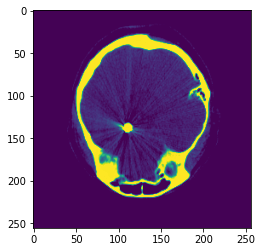

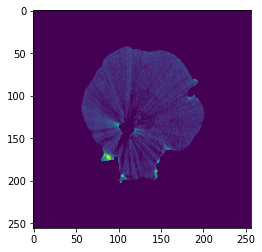

 50%|██████████████████████████████████████████                                          | 1/2 [00:08<00:08,  8.03s/it]

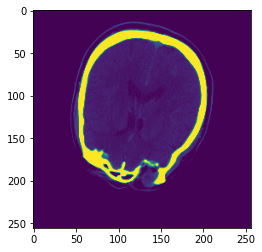

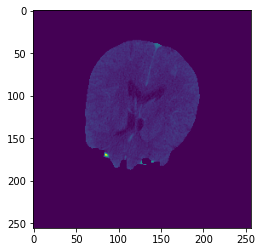

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.74s/it]


In [14]:
for case in tqdm(glob.glob(savepath+'\\*')):
    case_nr = case.split('\\')[-1]
    ctp_paths = glob.glob(r'D:\TRAINING\*\*4DPWI*\*4DPWI*.nii')
    ctp_path = [file for file in ctp_paths if '{}\\'.format(case_nr) in file][0]
    
    ctp_sitk = sitk.ReadImage(ctp_path)
    sequence = np.zeros(ctp_sitk.GetSize())

    
    # Find all files
    files = glob.glob(case+'\\reg_to_t0_ctp_*.nii.gz')

    # For the normal frames
    files = [file for file in files if 'flipped' not in file]
    times = [int(file.split('\\')[-1].split('_')[-1].split('.')[0]) for file in files]
    files = [x for _, x in sorted(zip(times, files))]
    
    series = []
    for ix in range(len(files)):
        temp_file = sitk.ReadImage(files[ix])
        series.append(temp_file)
    res = sitk.JoinSeries(series)
    brainmask_path = case+'\\brainmask.nii.gz'
    brainmask = sitk.ReadImage(brainmask_path)
    plt.imshow(sitk.GetArrayFromImage(res)[0,0,:,:])
    plt.show()
    res = ApplyMask(brainmask, res)
    plt.imshow(sitk.GetArrayFromImage(res)[0,0,:,:])
    plt.show()
    WritePerSlice(res, save_path=case, flipped=False)
#     folder = os.path.join(savepath,case)
#     save_file = os.path.join(folder,'ctp4d.nii.gz')
#     sitk.WriteImage(res, save_file)

    for file in files:
        os.remove(file)

#     del files, times, series, res, folder, save_file
#     # For the flipped frames

    files = glob.glob(case+'\\reg_to_t0_ctp_*_flipped.nii.gz')
    times = [int(file.split('\\')[-1].split('_')[-2]) for file in files]
    files = [x for _, x in sorted(zip(times, files))]
    
    series = []
    for ix in range(len(files)):
        temp_file = sitk.ReadImage(files[ix])
        series.append(temp_file)
    res = sitk.JoinSeries(series)
    brainmask_path = case+'\\brainmask_flipped.nii.gz'
    brainmask = sitk.ReadImage(brainmask_path)
    res = ApplyMask(brainmask, res)
    WritePerSlice(res, save_path=case, flipped=True)

#     folder = os.path.join(savepath,case)
#     save_file = os.path.join(folder,'ctp4d_flipped.nii.gz')
#     sitk.WriteImage(res, save_file)


    for file in files:
        os.remove(file)
    

In [ ]:
def Transformation(trans_params):
    !activate root
    command = (trans_params['transformix'] + 
        " -in " + trans_params['input_image'] + 
        " -out " + trans_params['output_dir'] + 
        " -tp " + trans_params['transform_file'] )

    subprocess.Popen(command, stdout=subprocess.PIPE).stdout.read()

trans_params = {'transformix':r'C:\Users\lucasdevries\Documents\elastix-5.0.1-win64\transformix.exe',
             }

In [ ]:
for case in tqdm(glob.glob(savepath+'\\*')):
    # Find all files
    files = sorted(glob.glob(case+'\\reg_to_t0_ctp_*'))
    for i in range(len(files)//2):
        fix = case + '\\reg_to_t0_ctp_3d_{}.nii.gz'.format(i)
        mov = case + '\\reg_to_t0_ctp_3d_{}_flipped.nii.gz'.format(i)
        fix_mask = case + '\\brainmask.nii.gz'.format(i)
        mov_mask = case + '\\brainmask_flipped.nii.gz'.format(i)
#         folder_name = fix.split('\\')[-1].split('.')[0]
        folder_name = 'sym_reg_ctp_3d_{}'.format(i)
        save_folder = os.path.join(case,folder_name)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        if i == 0:
            reg_params['output_dir'] = save_folder
            reg_params['fixed_image'] = fix
            reg_params['moving_image'] = mov
            reg_params['fixed_mask'] = fix_mask
            reg_params['moving_mask'] = mov_mask
            Registration(reg_params)
        break
    break
#         else:
#             transformation_file = r'D:\ISLES\case_1\sym_reg_ctp_3d_0\TransformParameters.0.txt'
#             trans_params['input_image'] = mov
#             trans_params['transform_file'] = transformation_file
#             trans_params['output_dir'] = save_folder
#             Transformation(trans_params)

<function dir>

In [ ]:
import nibabel as nib

In [ ]:
ctp = nib.load(r'D:\ISLES\case_1\brainmask_flipped.nii.gz').get_fdata()

In [ ]:
plt.imshow(ctp[:,:,4], vmin=0, vmax=1)
plt.show()

In [ ]:


# savepath = r'L:\basic\divi\CMAJOIE\CLEOPATRA\Substudies\Lucas\NOIV_MED_LATE_nii_ctp'





# load nifti
# clip nifti
# save nifi
# save flipped nifti

for case in tqdm(glob.glob(nifti_folder)):
    ID = case.split('\\')[-1]
    print(ID)
#     if os.path.exists(os.path.join(savepath,ID)):
#         continue
#     else:
#         os.makedirs(os.path.join(savepath,ID))
        
    for file in glob.glob(os.path.join(case,'*.nii.gz')):
        try:
#             RemoveBackground(file,savepath,ID)
#             saveloc = os.path.join(savepath,ID)
            CopyFile(file,savepath,ID)
        except:
            print(ID, ' failed!!!')
            continue



In [ ]:

def LargestConnectedComponent3D(img,min_threshold=-400, background=-1024):
    """
    Retrieves largest connected component mask for 3D sitk
    """
    # compute connected components (in 3D)
    cc = sitk.ConnectedComponent(img>min_threshold)
    stats = sitk.LabelIntensityStatisticsImageFilter()
    stats.Execute(cc,img)
    max_size = 0
    # get largest connected component
    for l in stats.GetLabels():
        if stats.GetPhysicalSize(l)>max_size:
            max_label = l
            max_size = stats.GetPhysicalSize(l)
    # return mask
    return sitk.BinaryThreshold(cc, max_label, max_label+1e-2)

def np_slicewise(mask, funcs, repeats=1):
    """
    Fills holes slice by slice of an 3D np volume
    """
    if isinstance(mask,sitk.SimpleITK.Image):
        mask = sitk.GetArrayFromImage(mask)
    out = np.zeros_like(mask)
    for sliceno in range(mask.shape[0]):
        m = mask[sliceno,:,:]
        for r in range(repeats):
            for func in funcs:
                m = func(m)
        out[sliceno,:,:] = m
    return out



def LargestConnectedComponent4D(CTP_sitk):
    """
    4D aternative to LargerstConnectedComponent3D.Iteraties over temporal dimension.
    Returns 4D mask with the only the largest connected component.

    """
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    t_dim = CTP_array.shape[0]
    frames = []
    for t in range(t_dim):
        img = sitk.GetImageFromArray(CTP_array[t])
        conn = LargestConnectedComponent3D(img, min_threshold=-400, background=-1024)
        mask = np_slicewise(conn, [binary_fill_holes])
        mask = np2itk(mask,conn)
        frames.append(mask)        
    img = sitk.JoinSeries(frames)
    
    # restore original spacing, origin, direction...
    img.SetSpacing(CTP_sitk.GetSpacing())
    img.SetOrigin(CTP_sitk.GetOrigin())
    img.SetDirection(CTP_sitk.GetDirection())
    img.CopyInformation(CTP_sitk) 
    return img

def ApplyMask(MASK_sitk, CTP_sitk, foreground_m=0, background=None, sitk_type = sitk.sitkInt32):
    """
    Applies mask (m) to 4D volume, sets background of image
    returns and 4D volume with only mask foreground.
    """
    if foreground_m == 0:
        mf = sitk.MaskNegatedImageFilter()
    elif foreground_m == 1:
        mf = sitk.MaskImageFilter()
    if background != None:
        mf.SetOutsideValue(background)
        
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    MASK_array = sitk.GetArrayFromImage(MASK_sitk) # T x D x H x W
    t_dim = CTP_array.shape[0]
    frames = []
    for t in range(t_dim):
        im = sitk.GetImageFromArray(CTP_array[t])
        im = sitk.Cast(im,sitk_type)
        
        mask = sitk.GetImageFromArray(MASK_array[t])
        mask = sitk.Cast(mask,sitk_type)
        
        result = mf.Execute(im, mask)
        frames.append(result)
        
    img = sitk.JoinSeries(frames)
    # restore original spacing, origin, direction...
    img.SetSpacing(CTP_sitk.GetSpacing())
    img.SetOrigin(CTP_sitk.GetOrigin())
    img.SetDirection(CTP_sitk.GetDirection())
    img.CopyInformation(CTP_sitk) 

    return img

def WritePerVolume(CTP_sitk, save_path):
#     sitk.WriteImage(CTP_sitk, os.path.join(save_path,'ctp_4d.nii.gz'))
    CTP_array = sitk.GetArrayFromImage(CTP_sitk) # T x D x H x W
    t_dim = CTP_array.shape[0]
    for t in range(t_dim):
        im = sitk.GetImageFromArray(CTP_array[t])
        im.SetSpacing(CTP_sitk.GetSpacing())
        im.SetOrigin(CTP_sitk.GetOrigin())
        sitk.WriteImage(im, os.path.join(save_path, 'ctp_3d_{}.nii.gz'.format(t)))
        
def RemoveBackground(CTP_path, save_path, ID):
    background = -1024
    CTP_sitk = sitk.ReadImage(CTP_path)
    CTP_spacing_z = CTP_sitk.GetSpacing()[2]
    foldername = ID+'_'+str(CTP_spacing_z).replace('.', '_')
    save_file_name = os.path.join(savepath,ID,foldername)
    if not os.path.exists(save_file_name):
        os.makedirs(save_file_name)
    print(save_file_name)
#     # Clipping part
    CTP_sitk = Clipper(CTP_sitk)
    # Largest component and fill holes
    CTP_mask = LargestConnectedComponent4D(CTP_sitk)
    # Apply the mask to the CTP
    CTP_sitk = ApplyMask(CTP_mask, CTP_sitk, foreground_m=1, background=background) 
    WritePerVolume(CTP_sitk, save_file_name)

In [ ]:
def CopyFile(CTP_path, save_path, ID):
    print(CTP_path)
    json_path = CTP_path[:-7] + '.json'
    CTP_sitk = sitk.ReadImage(CTP_path)
    CTP_spacing_z = CTP_sitk.GetSpacing()[2]
    foldername = ID+'_'+str(CTP_spacing_z).replace('.', '_')
    save_file_name = os.path.join(savepath,ID,foldername)
    json_save_name = os.path.join(savepath,ID,foldername,foldername)+'.json'
    
#     print(json_path)
#     print(json_save_name)
    copyfile(json_path, json_save_name)


In [ ]:
nifti_folder = r'L:\basic\divi\CMAJOIE\CLEOPATRA\Substudies\Lucas\NOIV_MED_LATE_nii\*'
# savepath = r'L:\basic\divi\CMAJOIE\CLEOPATRA\Substudies\Lucas\NOIV_MED_LATE_nii_ctp'
savepath = r'D:\NOIV_MED_LATE_nii_ctp'
for case in tqdm(glob.glob(nifti_folder)):
    ID = case.split('\\')[-1]
    print(ID)
#     if os.path.exists(os.path.join(savepath,ID)):
#         continue
#     else:
#         os.makedirs(os.path.join(savepath,ID))
        
    for file in glob.glob(os.path.join(case,'*.nii.gz')):
        try:
#             RemoveBackground(file,savepath,ID)
#             saveloc = os.path.join(savepath,ID)
            CopyFile(file,savepath,ID)
        except:
            print(ID, ' failed!!!')
            continue
